In [42]:
import sys
import math
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import os

# Computing distance to line

An essential part of getting the robot to behave correctly around street lights is for it to know its distance to the light. On actual roads in Switzerland and many other countries, at every light there is a stop line painted on the road. We do the same in our context and thus the distance to the street light is equivalent to the distance to the stop line on the road.

Below is an example of a typical picture taken by the robot during one of its runs, where the stop line is starting to appear. The whole set of pictures from that run can be found in the folder /images/.

![title](images/27.jpg)

Write a function that takes an image as input and returns a distance to the line (not necessarily in cm). To make sure it is robust, find a way to augment your test set from the given images.

Use OpenCV, which you can install through Anaconda, to process the images. Then you can choose between using the OpenCV library to detect the line or implementing your own procedure, keeping in mind that the function should be as fast as possible. 

### Theory, ideas 

We begin by detecting horizontal lines (hence the line we are interested in) using the probabilistic Hough transform.(which is musch faster than the simple one)

We preprocess the image using the Canny edge detection, then dilating the edges to be sure to have a good detection and to not miss the line (comparative tests should be done a little bit later to determine if this is really necessary)

Then we define our new distance as follows :  

![alt text](images/hnew_distance_explanation.jpg "Exemple of the lines actually detected (we ignored some vertical lines) from image 101 in the dataset")

This is one example of the image we get using the following code :  

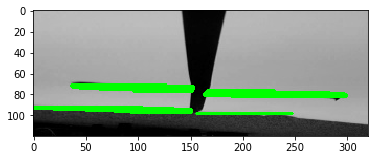

In [40]:
kernel = np.ones((5,5),np.uint8)
canny_max_val=500
canny_min_val=400
minLineLength = 100
maxLineGap = 50
threshold = 100
closer = 0
distance = 100000000000

#we load the image 
img = cv2.imread('images/101.jpg')

#we convert it to gray scale since we are interested in finding a black line over a white surface 
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#first canny edge detection
edges = cv2.Canny(gray,canny_min_val,canny_max_val,apertureSize = 3)

#then the dilatation
edges = cv2.dilate(edges,kernel)

#then the probabilistic Hough transform
lines = cv2.HoughLinesP(edges,1,np.pi/2,threshold,minLineLength,maxLineGap)

#visualisation
for index,line in enumerate(lines):
    for x1,y1,x2,y2 in line :
        if y2 != 0 and abs(y2-y1)<=epsilon:  #avoid finding vertical lines starting at the origin
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
        if y1<distance or y2 < distance:
            closer = index
            distance = min(y1,y2)   
plt.imshow(img)
plt.show()

The visualisation is not mandatory, but just helps us

The distance si defined as the distance between the origin (our robot) and the closest horizontal line : `distance` is defined this way so we are sure we didn't cross the line. 

One problem it might cause is that if the black line is in a curve (not real case...) this might give some bizarre results

We actually define the relative distance to the line as `dsitance`. But we have some problem with the "end of the world" detection : here are some solutions that shall be tested later : 
1. find the total length of the image in pixels (this is basically our new unit of distance) then when measuring distance, say that if the detected distance is superior to the length of the image minus a certain small distance (to be defined from experience) then consider the distance to be infinite : hence our robot will act as if there is no horizontal band 
2. find the horizon and try to find the actual band : this way if we have two bands we know that we are measuring actually the distance to a pseudo traffic light, otherwise proceed as told before.


but this may be not enough : the pictures are quite clear and clean in this dataset but otherwise we could think of apllying a gaussian blurr to delete noise.

Another improvement that could be make is that we could find the angle from a vertical in the lines we find : if this angle $\theta$ is too small we decide to not look at this line : hence we mininize the risk of detecting a length $0$ as we can have when we have perfectly vertical lines (or near perfect), for now this sorting is done by not taking into account lines that begin at $0$ but we might detect some starting near $0$ but not exactly and hence being trapped

we can now proceed to measuring the distance when we actually "move" : for each image where we measure the distance, we have to compare it to the previous distance(s) calculated and maybe to the one after

### Actual computations

minLineLength - Minimum length of line. Line segments shorter than this are rejected.


maxLineGap - Maximum allowed gap between line segments to treat them as single line.

1.jpg


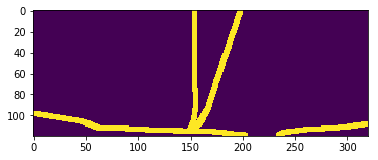

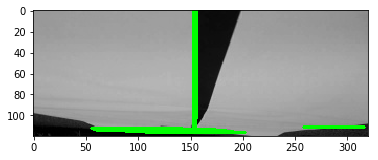

10.jpg


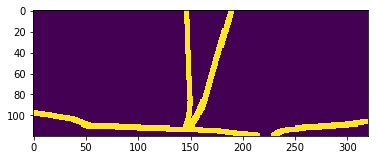

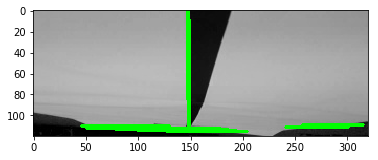

101.jpg


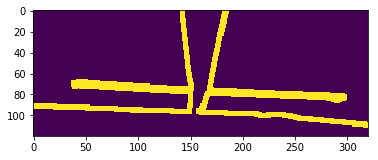

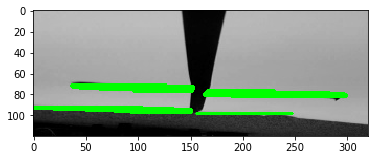

103.jpg


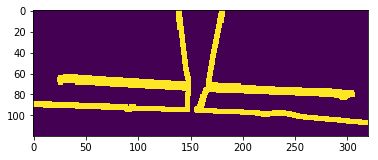

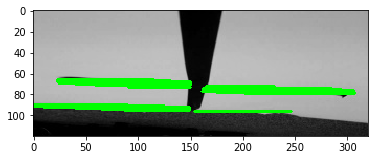

105.jpg


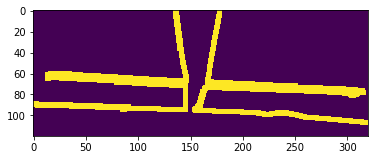

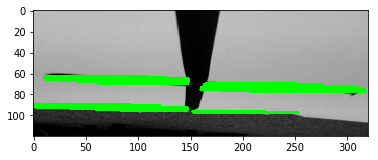

108.jpg


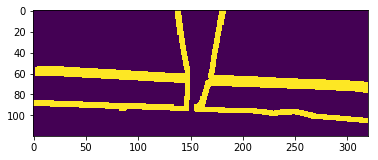

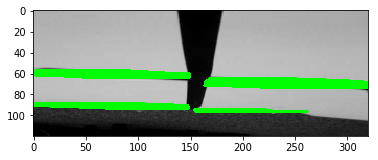

110.jpg


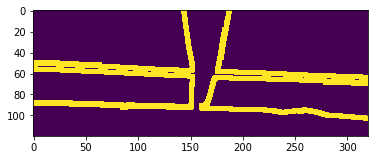

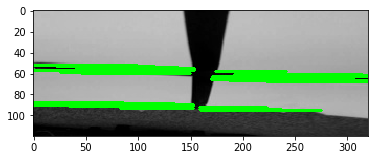

113.jpg


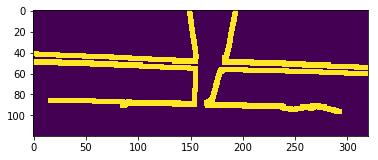

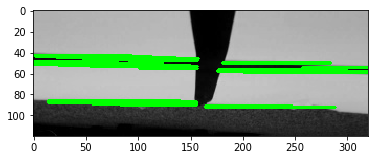

116.jpg


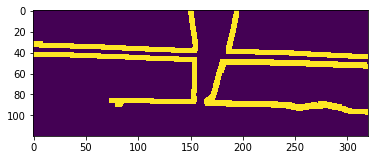

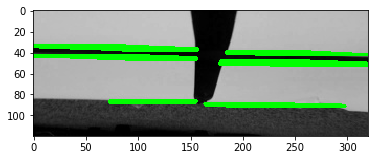

118.jpg


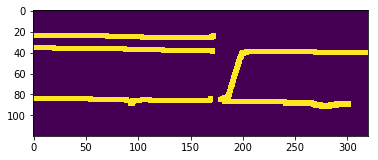

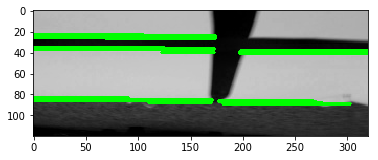

121.jpg


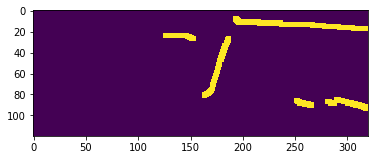

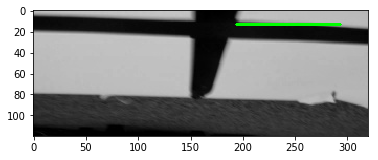

123.jpg


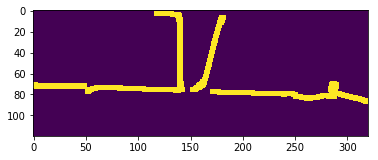

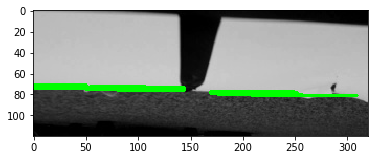

125.jpg


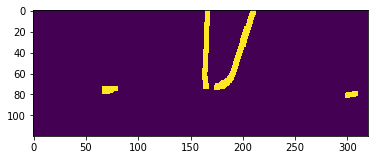

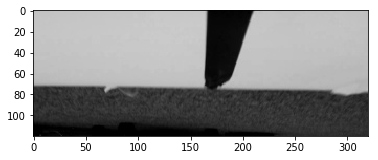

128.jpg


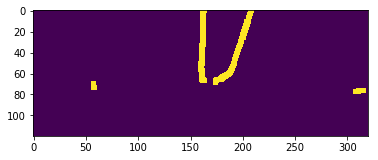

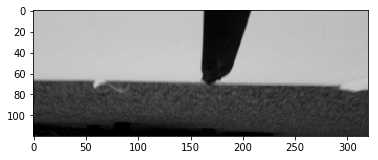

13.jpg


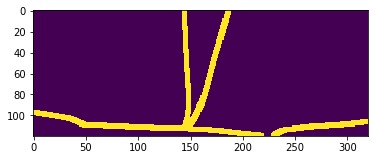

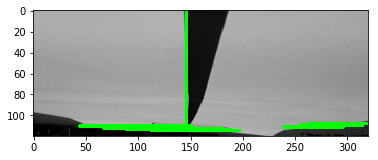

130.jpg


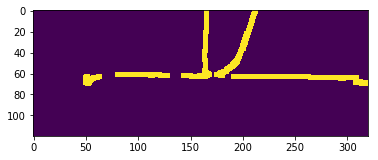

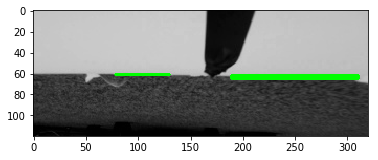

133.jpg


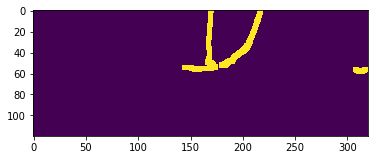

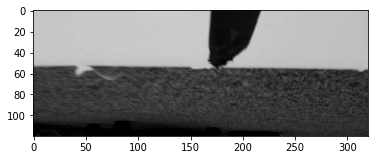

135.jpg


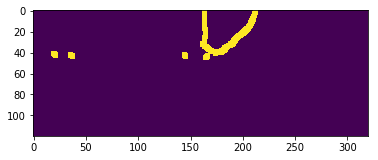

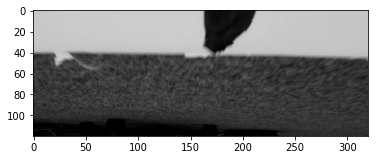

138.jpg


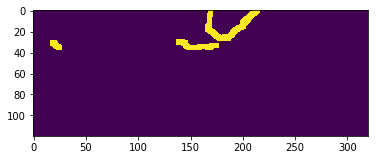

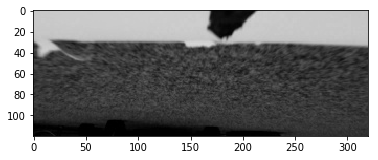

140.jpg


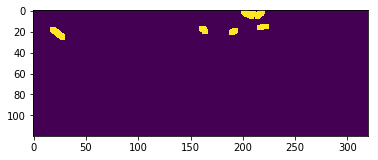

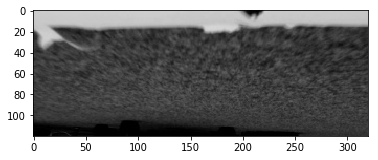

142.jpg


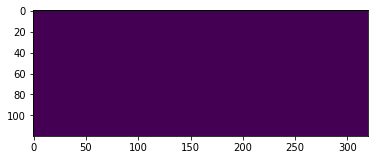

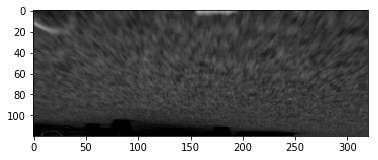

145.jpg


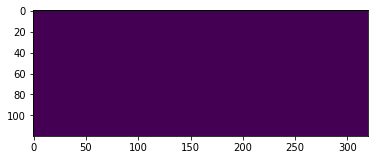

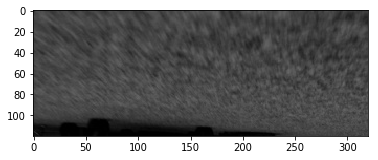

147.jpg


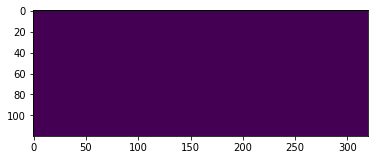

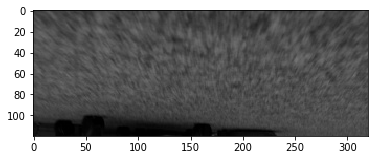

149.jpg


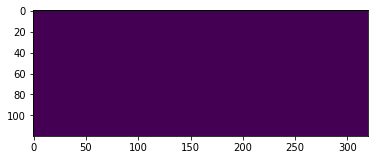

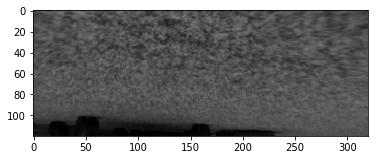

15.jpg


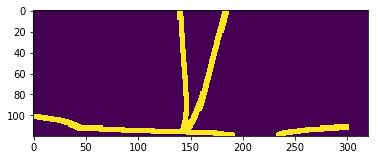

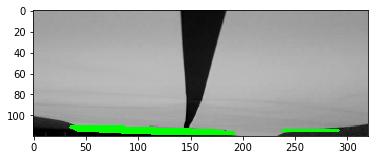

18.jpg


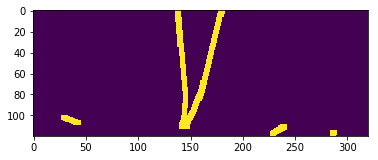

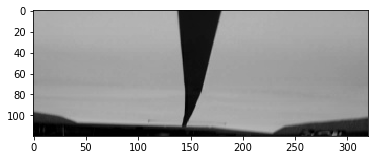

20.jpg


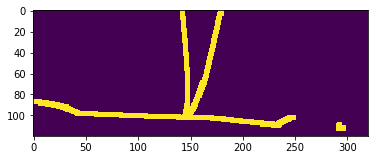

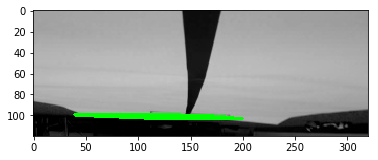

22.jpg


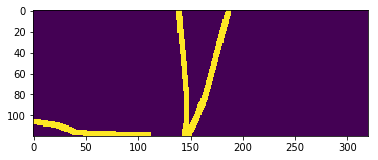

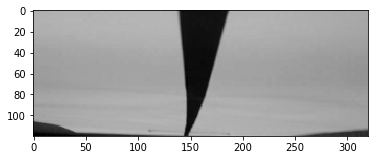

25.jpg


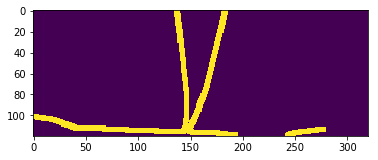

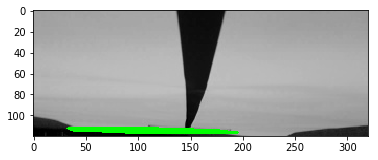

27.jpg


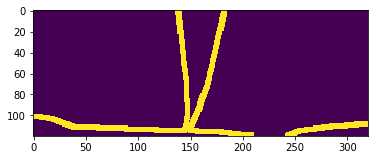

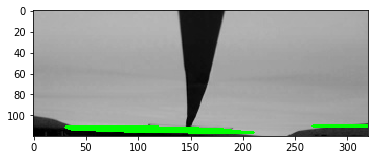

3.jpg


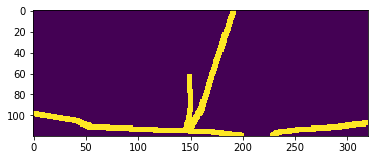

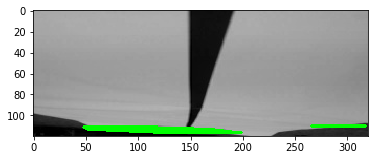

30.jpg


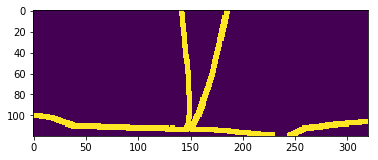

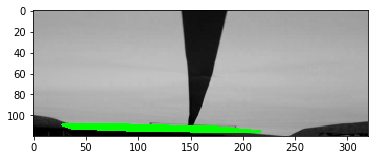

32.jpg


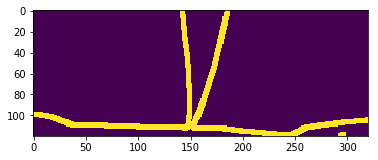

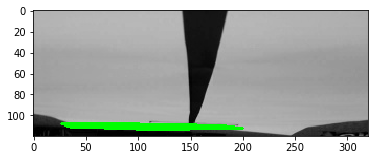

35.jpg


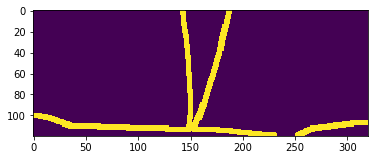

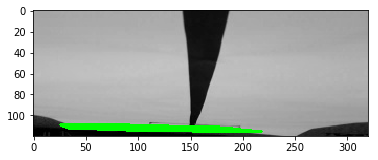

37.jpg


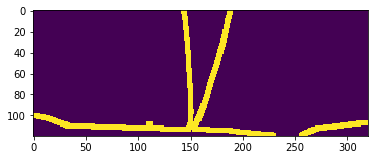

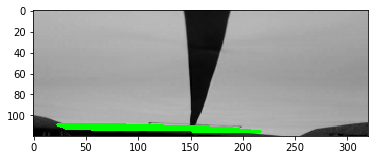

40.jpg


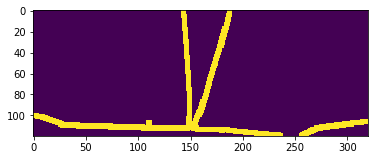

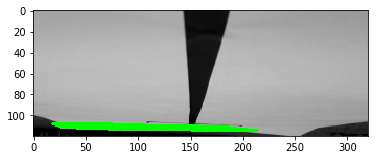

42.jpg


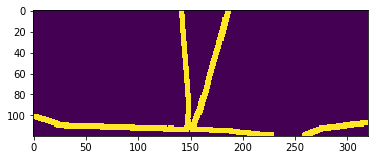

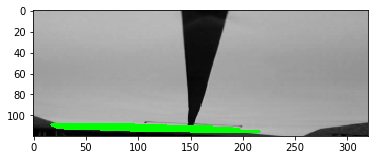

44.jpg


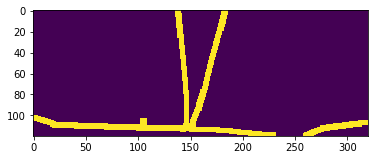

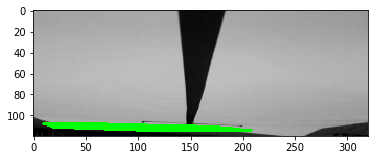

47.jpg


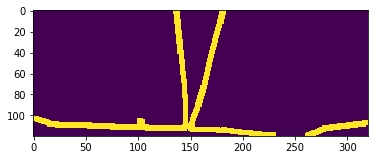

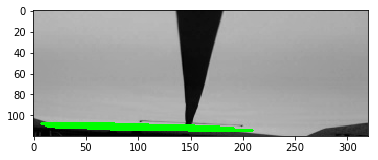

49.jpg


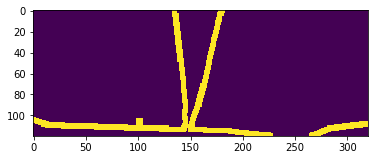

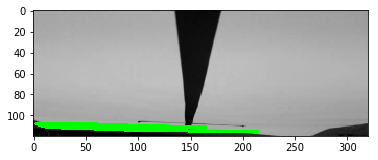

5.jpg


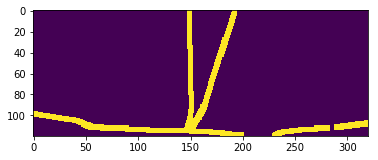

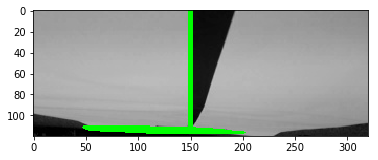

52.jpg


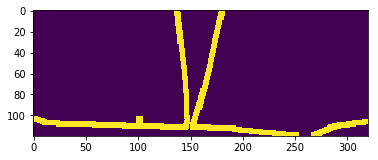

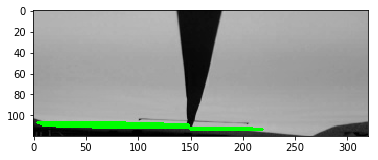

54.jpg


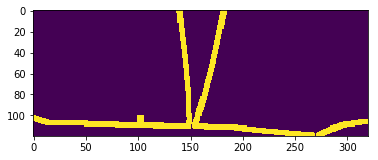

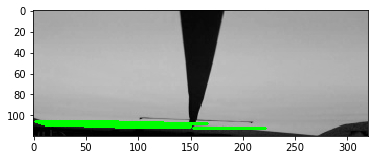

57.jpg


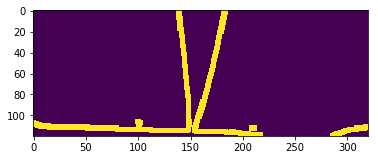

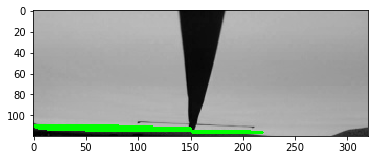

59.jpg


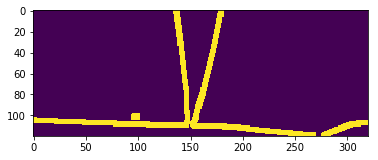

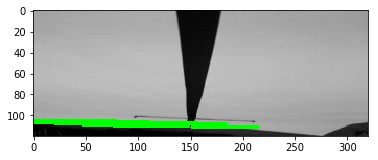

62.jpg


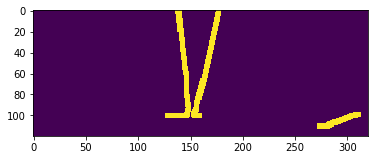

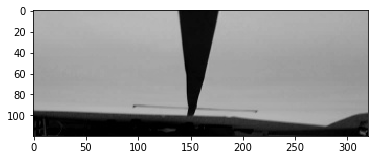

64.jpg


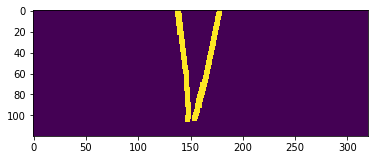

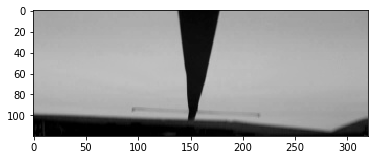

66.jpg


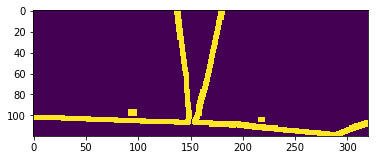

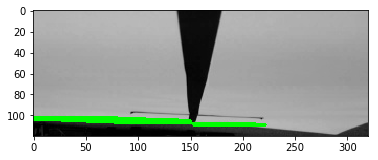

69.jpg


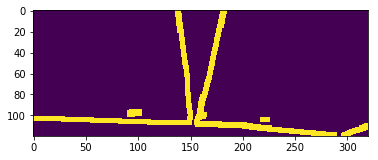

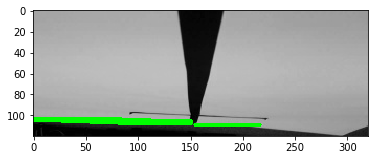

71.jpg


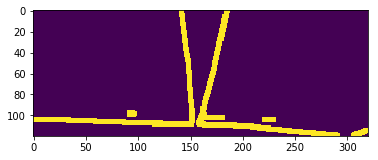

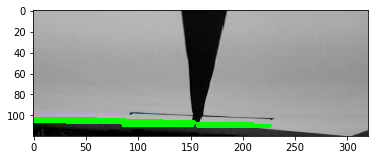

74.jpg


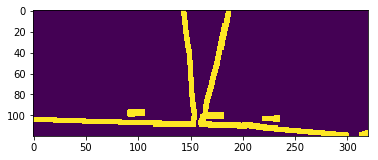

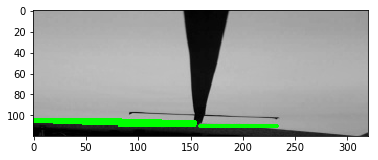

76.jpg


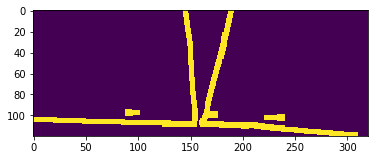

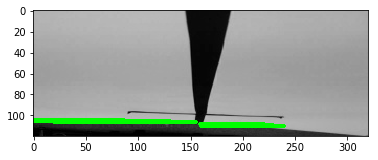

79.jpg


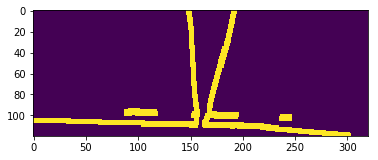

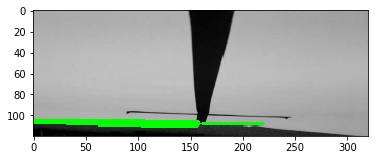

8.jpg


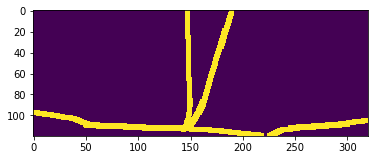

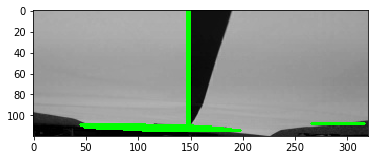

81.jpg


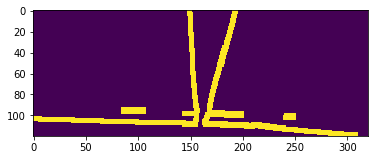

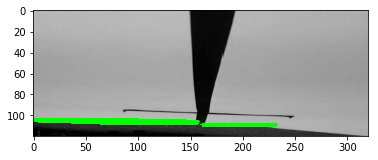

83.jpg


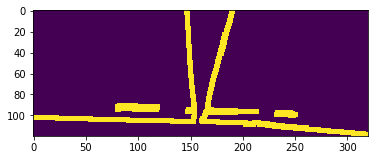

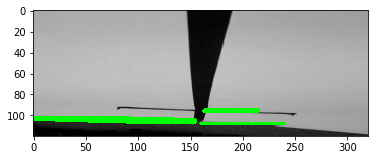

86.jpg


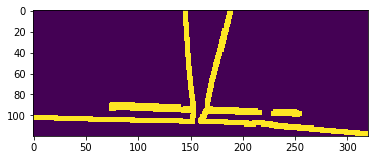

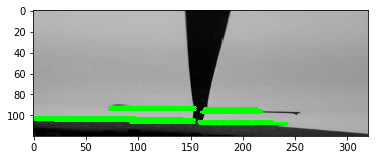

88.jpg


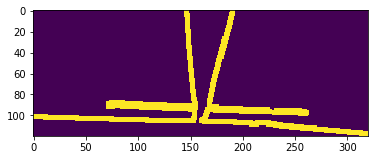

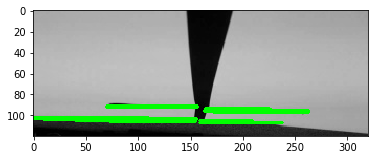

91.jpg


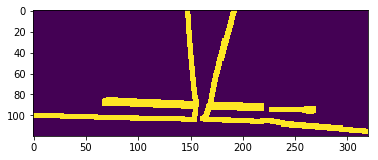

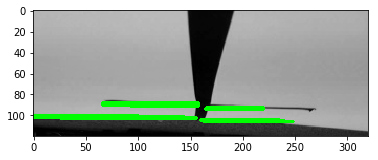

93.jpg


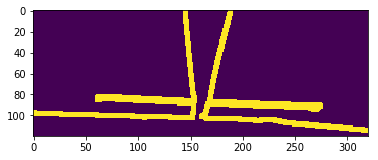

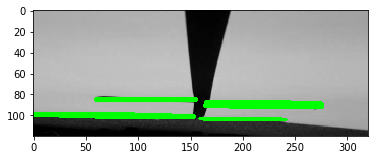

96.jpg


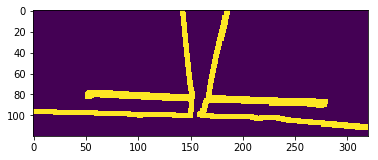

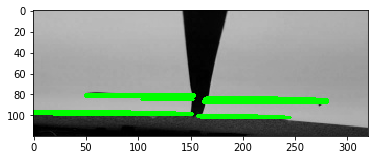

98.jpg


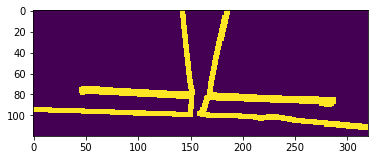

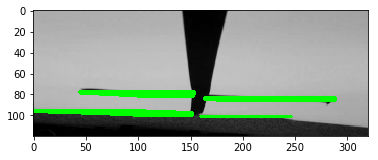

hnew_distance_explanation.jpg


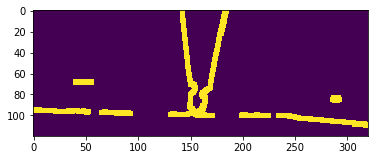

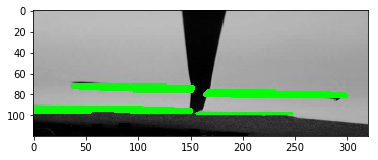

houghlines5.jpg


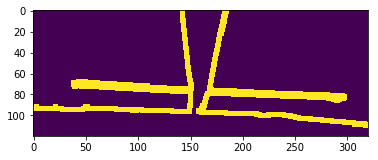

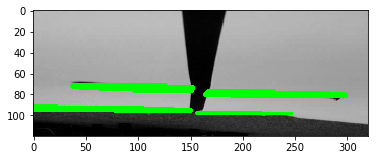

10.94


In [41]:

kernel = np.ones((5,5),np.uint8)
canny_max_val=500
canny_min_val=400
minLineLength = 100
maxLineGap = 50
threshold = 100

L=0
n=0

for filename in os.listdir('images'):
    img = cv2.imread(os.path.join('images/'+filename))
    print(filename)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,canny_min_val,canny_max_val,apertureSize = 3)
    edges = cv2.dilate(edges,kernel)
    plt.imshow(edges)
    plt.show()
    lines = cv2.HoughLinesP(edges,1,np.pi/2,threshold,minLineLength,maxLineGap)
    try :
        #print(len(lines))
        L+=len(lines)
        n+=1
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    except : 
        pass
    #print(os.path.join('images/'+filename))
    plt.imshow(img)
    plt.show()    

print(L/n)

### Tests/garbage

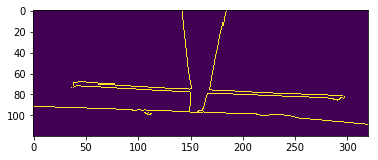

[[[ 0 91 48 92]]]


True

In [9]:
import cv2
import numpy as np

img = cv2.imread('images/101.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200,apertureSize = 3)
plt.imshow(edges)
plt.show()
minLineLength = 0.1
maxLineGap = 40
lines = cv2.HoughLinesP(edges,1,np.pi/360,100,minLineLength,maxLineGap)
print(lines)
for line in lines:
    for x1,y1,x2,y2 in line :
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

cv2.imwrite('images/houghlines5.jpg',img)

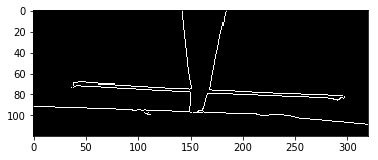

In [8]:
img=cv.imread('images/101.jpg')
edges=cv.Canny(img,150,200)
plt.imshow(edges, cmap = 'gray')
plt.show()